In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import bernoulli
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC

In [2]:
np.random.seed(1457065)
n_gen = 50
n_samples = 4*n_gen
data_red_1 = np.random.multivariate_normal(mean=np.array([2,2]),
                                             cov=np.array(([1,-0.25],[-0.25,1])),
                                             size=n_gen)
data_red_2 = np.random.uniform(low=1.0, high=3.0, size=(n_gen,2))

data_blue_1 = np.random.multivariate_normal(mean=np.array([-1,-1]),
                                            cov=np.eye(2)*0.5,
                                            size=n_gen)
data_blue_2 = np.random.uniform(low=-2, high=-1, size=(n_gen,2))

data_red = np.vstack((data_red_1,data_red_2))
labels_red = (np.ones(2*n_gen)*-1).reshape(2*n_gen,1)
data_red = np.hstack((data_red,labels_red))

data_blue = np.vstack((data_blue_1, data_blue_2))
labels_blue = (np.ones(2*n_gen)).reshape(2*n_gen,1)
data_blue = np.hstack((data_blue,labels_blue))

whole_data = np.vstack((data_blue, data_red))

In [3]:
data_df = pd.DataFrame(whole_data)
data_df.columns = ['x1','x2','class']
data_df['label'] = np.ones(n_samples)*(-1)
for i in range(n_samples):
    random = bernoulli.rvs(p=3/4)
    if data_df.loc[i,'class'] == 1 and random == 0:
        data_df.loc[i,'label'] = 1
n_positives = data_df[data_df['label'] == 1].shape[0]

In [4]:
positive_instances = data_df[data_df['label'] == 1]
unlabelled_set = data_df[data_df['label'] == -1]
df_for_results = data_df.copy()
t = 15
for i in range(t):
    u_t = unlabelled_set.sample(n=n_positives)
    train_set = pd.concat([positive_instances,u_t])
    indexes_to_drop = list(train_set.index)
    f_t = SVC(decision_function_shape='ovr').fit(X=train_set.to_numpy()[:,:-2],y=train_set['label'].to_numpy())
    to_be_pred = data_df.drop(labels=indexes_to_drop,axis=0)
    predictions = f_t.decision_function(X=to_be_pred.to_numpy()[:,:-2])
    to_be_pred[f'score_{i}'] = predictions
    df_pred = pd.DataFrame(to_be_pred[f'score_{i}'])
    df_for_results = df_for_results.merge(df_pred, how='left', left_index=True,right_index=True)

In [5]:
indexes_positive = list(df_for_results[df_for_results['label'] == 1].index)
last_df = df_for_results.drop(labels=indexes_positive,axis=0).copy()
last_df = last_df.drop(['x1','x2','label'],axis=1)
classes_for_comp = last_df['class'].copy().to_numpy()
last_df = last_df.drop(['class'], axis=1)
average = last_df.mean(axis=1).to_numpy()
positive = 0
true_positive = 0
for i in range(average.shape[0]):
    average[i] = np.sign(average[i])
for i in range(average.shape[0]):
    if average[i] == 1:
        positive += 1
        if classes_for_comp[i] == 1:
            true_positive += 1



precision = true_positive/(positive)
recall = true_positive/((n_gen*2)) #accurately positive predicted instances/#the total number of positives
f_1_score = (2*recall*precision)/(precision+recall)
weird_estimation_score = (recall**2)/(positive/n_samples)
print('the precision on the test data is : ', precision, '\n',
     'the recall on the test data is : ', recall, '\n',
     'the f_1 score on the test data is : ', f_1_score, '\n',
     'the strange estimator is given by : ', weird_estimation_score)

the precision on the test data is :  1.0 
 the recall on the test data is :  0.8 
 the f_1 score on the test data is :  0.888888888888889 
 the strange estimator is given by :  1.6000000000000003


In [6]:
#obviously works pretty well as the data is very much separable

In [7]:
#now let's try some plots

In [8]:
Z = np.zeros((500**2,1))
Z = pd.DataFrame(Z)
Z.columns = ['init']
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-4, 5, 500))
for i in range(t):
    u_t_z = unlabelled_set.sample(n=n_positives)
    train_set_z = pd.concat([positive_instances,u_t_z])
    indexes_to_drop = list(train_set_z.index)
    f_t = SVC(decision_function_shape='ovr').fit(X=train_set_z.to_numpy()[:,:-2],y=train_set_z['label'].to_numpy())
    to_be_pred = data_df.drop(labels=indexes_to_drop,axis=0)
    predictions_z = f_t.decision_function(X=np.c_[xx.ravel(), yy.ravel()])
    Z[f'score_{i}'] = predictions_z


In [9]:
#Z = np.zeros((500**2,1))
#Z = pd.DataFrame(Z)
#Z.columns = ['init']
#xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-4, 5, 500))
#Z = f_t.decision_function(np.c_[xx.ravel(), yy.ravel()])
#Z = Z.reshape(xx.shape)

In [10]:
Z = Z.drop(['init'],axis=1)
Z = Z.mean(axis=1)
Z = Z.to_numpy()
Z = Z.reshape(xx.shape)

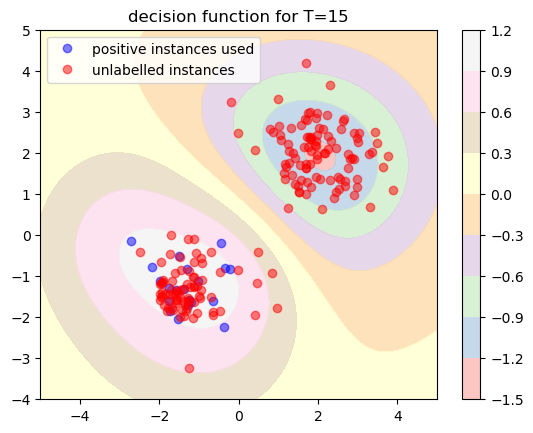

In [11]:
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.Pastel1)
plt.plot(positive_instances.to_numpy()[:,0], positive_instances.to_numpy()[:,1], 'bo', alpha=0.5,label='positive instances used')
plt.plot(unlabelled_set.to_numpy()[:,0], unlabelled_set.to_numpy()[:,1], 'ro', alpha=0.5, label='unlabelled instances')
plt.title(f'decision function for T={t}')
plt.legend()
plt.colorbar()

In [12]:
binary_z = Z.copy()
for i in range(Z.shape[0]):
    for k in range(Z.shape[1]):
        binary_z[i,k] = np.sign(binary_z[i,k])

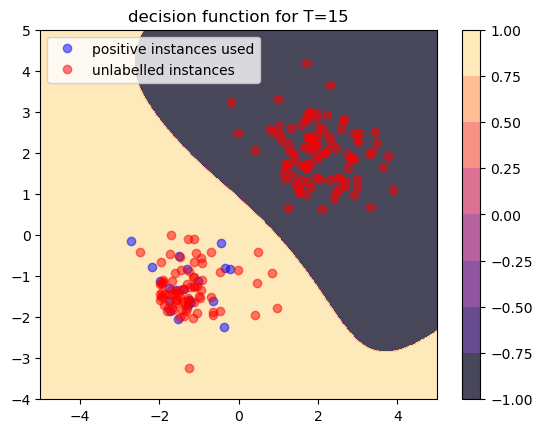

In [13]:
plt.contourf(xx, yy, binary_z, alpha=0.75, cmap=plt.cm.magma)
plt.plot(positive_instances.to_numpy()[:,0], positive_instances.to_numpy()[:,1], 'bo', alpha=0.5,label='positive instances used')
plt.plot(unlabelled_set.to_numpy()[:,0], unlabelled_set.to_numpy()[:,1], 'ro', alpha=0.5, label='unlabelled instances')
plt.title(f'decision function for T={t}')
plt.legend()
plt.colorbar()